# Teoría de Redes Complejas en Econofísica

## Conceptos Fundamentales

### 1. **Redes de Correlación Financiera**
En econofísica, los mercados financieros se modelan como sistemas complejos donde los activos son **nodos** y las correlaciones entre sus retornos son **aristas (conexiones)**.

- **Hipótesis**: Activos con correlaciones altas tienden a moverse conjuntamente, reflejando dependencias económicas, factores de riesgo comunes, o sectores similares.
- **Umbral de Correlación**: Se establece un valor mínimo (ej: 0.7) para considerar que dos activos están "conectados", eliminando ruido y conexiones débiles.

### 2. **Grado Medio de la Red (⟨k⟩)**
Métrica que cuantifica la **densidad promedio de conexiones**:

$$\langle k \rangle = \frac{1}{N} \sum_{i=1}^{N} k_i = \frac{2E}{N}$$

Donde:
- $k_i$ = número de conexiones del nodo $i$
- $N$ = número total de nodos
- $E$ = número total de aristas

**Interpretación**:
- $\langle k \rangle$ bajo → Red dispersa (pocos activos correlacionados)
- $\langle k \rangle$ alto → Red densa (muchas correlaciones)

### 3. **Modularidad (Q)**
Mide la **fuerza de la estructura comunitaria** en la red. Cuantifica si la red tiene **clustering natural** (grupos de activos que se correlacionan internamente más que externamente).

$$Q = \frac{1}{2E} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2E} \right) \delta(c_i, c_j)$$

Donde:
- $A_{ij}$ = matriz de adyacencia
- $k_i, k_j$ = grados de los nodos
- $\delta(c_i, c_j)$ = función que vale 1 si $i$ y $j$ están en la misma comunidad

**Interpretación**:
- $Q > 0.3$ → Estructura comunitaria **fuerte** (clusters bien definidos)
- $0 < Q < 0.3$ → Estructura comunitaria **débil**
- $Q \leq 0$ → No hay estructura comunitaria significativa

### 4. **Algoritmo de Louvain**
Método de **detección de comunidades** que maximiza la modularidad:

1. Inicialmente, cada nodo es su propia comunidad
2. Iterativamente, se mueven nodos a otras comunidades si aumenta $Q$
3. Se repite hasta convergencia

**Aplicación financiera**: Identifica **sectores o grupos de activos** con comportamiento similar.

### 5. **Interpretación Económica**
- **Comunidades**: Representan sectores o factores de riesgo comunes (ej: tecnología, energía, commodities)
- **Puentes entre comunidades**: Activos que conectan diferentes sectores (diversificadores de portafolio)
- **Centralidad**: Activos muy conectados suelen ser índices o activos sistémicos

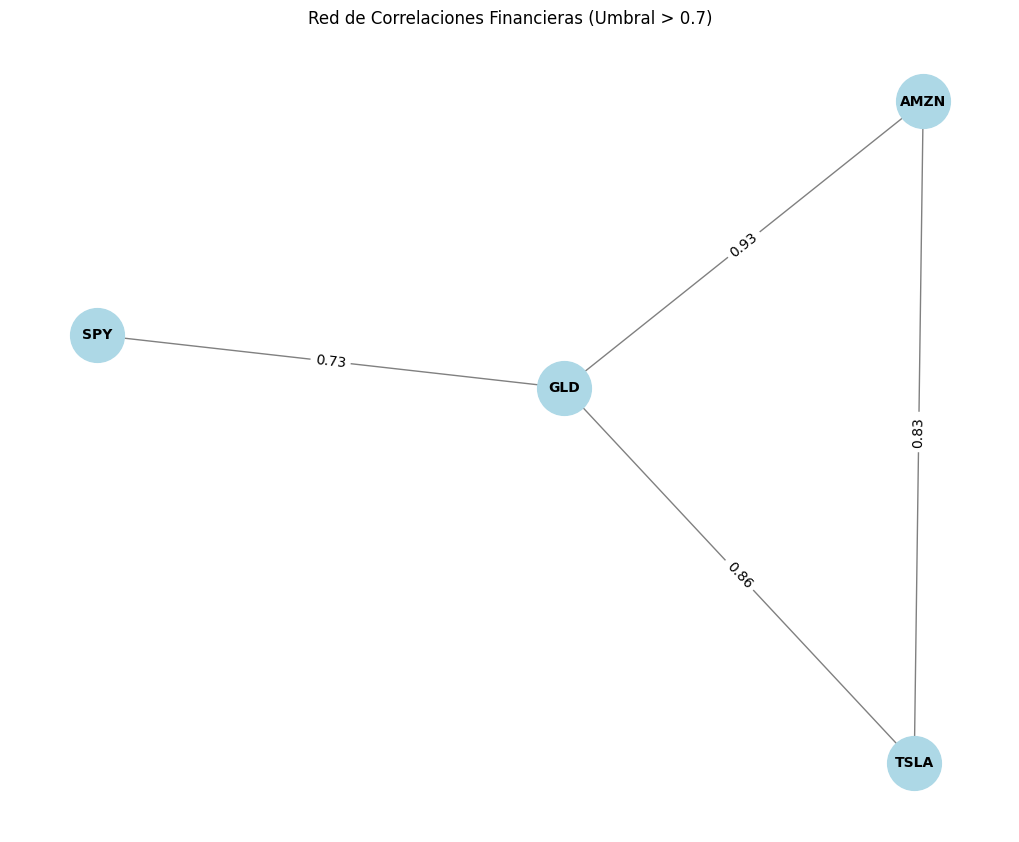


ANÁLISIS TOPOLÓGICO DE LA RED FINANCIERA

Estructura de la Red:
  Número de Nodos (Activos): 4
  Número de Aristas (Correlaciones > 0.7): 4

Métricas de Red:
  Grado Medio (⟨k⟩): 2.0000
    → Promedio de conexiones por activo

  Modularidad (Q): -0.0000
    → Fuerza de estructura comunitaria

  ◯ SIN ESTRUCTURA COMUNITARIA (Q ≤ 0)
    Red cercana a aleatoria. Activos independientes.

----------------------------------------------------------------------
COMUNIDADES IDENTIFICADAS (Algoritmo de Louvain):
----------------------------------------------------------------------

Comunidad 0: AMZN, TSLA, GLD, SPY
  Tamaño: 4 activos
  Interpretación: Grupo de activos correlacionados



In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain

# ============================================================================
# CONSTRUCCIÓN DE UNA RED FINANCIERA A PARTIR DE CORRELACIONES
# ============================================================================
# En econofísica, modelamos el mercado como un SISTEMA COMPLEJO donde:
# - NODOS = Activos financieros (acciones, índices, commodities)
# - ARISTAS = Correlaciones de retornos entre activos
# 
# Intuición: Si dos activos están altamente correlacionados, comparten
# factores de riesgo comunes (sector, macroeconomía, etc.)
# ============================================================================

# --- Simulación de datos de precios para la demostración ---
np.random.seed(42)
T = 252  # Días de negociación (aproximadamente 1 año)
activos = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'SPY', 'GLD', 'VIX']
N_activos = len(activos)

# GENERACIÓN DE RETORNOS CORRELACIONADOS
# ========================================
# Creamos una matriz de retornos con correlaciones artificiales realistas.
# En mercados reales, existen grupos de activos que se mueven juntos:
# - Tecnología (AAPL, GOOGL, MSFT, AMZN, TSLA)
# - Índices/Commodities (SPY, GLD, VIX)

returns = np.random.randn(T, N_activos)
# Introducir correlación: el sector tecnológico (primeras 4 columnas)
# comparte un factor de riesgo común
returns[:, 0:4] += np.random.randn(T, 1) * 0.5

# Convertir retornos a precios usando proceso lognormal
# P(t) = P(0) * exp(sum(retornos))
precios = 100 * np.exp(np.cumsum(returns, axis=0) * 0.01)
df = pd.DataFrame(precios, columns=activos)

# --- Construcción de la red mediante matriz de correlación ---
# 
# La MATRIZ DE CORRELACIÓN r_ij mide la dependencia lineal entre
# los retornos de dos activos. Rango: [-1, 1]
# 
# INTERPRETACIÓN:
# - r_ij ≈ 1 → Movimiento conjunto (correlación positiva)
# - r_ij ≈ -1 → Movimiento opuesto (correlación negativa)
# - r_ij ≈ 0 → Sin relación lineal

corr = df.corr()

# UMBRAL DE CORRELACIÓN
# =====================
# Para evitar ruido estadístico, solo conectamos activos con
# correlación > umbral. Esto mantiene solo conexiones "significativas".
# Valor típico: 0.6 - 0.8 (más alto = red más sparse)

G = nx.Graph()
umbral_corr = 0.7

for i in corr.columns:
    for j in corr.columns:
        if i != j and corr.loc[i, j] > umbral_corr:
            # Creamos una arista ponderada (peso = valor de correlación)
            G.add_edge(i, j, weight=corr.loc[i, j])

# VISUALIZACIÓN DE LA RED
# =======================
# Usamos layout de Fruchterman-Reingold (spring layout):
# - Repulsión entre nodos (evita solapamiento)
# - Atracción proporcional a los pesos (aristas con mayor correlación 
#   hacen que los nodos se acerquen)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, weight='weight', iterations=50)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', 
        font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
plt.title(f'Red de Correlaciones Financieras (Umbral > {umbral_corr})')
plt.xlabel('Activos están conectados si correlación > 0.7')
plt.show()

# ============================================================================
# ANÁLISIS TOPOLÓGICO: GRADO MEDIO Y MODULARIDAD
# ============================================================================

# 1. GRADO MEDIO DE LA RED (⟨k⟩)
# ==================================
# Mide la DENSIDAD PROMEDIO de conexiones en la red.
# Definición: ⟨k⟩ = (2 * |E|) / |V|
# 
# SIGNIFICADO FINANCIERO:
# - Red con ⟨k⟩ alto: Mercado altamente correlacionado
#   → Mayor riesgo sistémico (movimientos conjuntos)
#   → Menor beneficio de diversificación
# 
# - Red con ⟨k⟩ bajo: Activos con dinámicas independientes
#   → Mejor oportunidades de diversificación

if G.number_of_nodes() > 0:
    grados = [G.degree(node) for node in G.nodes()]
    grado_medio = np.mean(grados)
else:
    grado_medio = 0

# 2. MODULARIDAD (Q)
# ==================
# Métrica que cuantifica si la red tiene ESTRUCTURA COMUNITARIA.
# 
# TEORÍA:
# Q mide el balance entre:
# - Aristas DENTRO de comunidades (conexiones reales)
# - Aristas ENTRE comunidades (conexiones aleatorias esperadas)
#
# RANGO: [-1, 1]
# 
# INTERPRETACIÓN:
# Q > 0.3 → Red tiene ESTRUCTURA COMUNITARIA FUERTE (clusters bien definidos)
# 0 < Q < 0.3 → Estructura débil (mezcla de conexiones)
# Q ≤ 0 → Red aleatoria (sin estructura comunitaria)
#
# APLICACIÓN FINANCIERA:
# Alta modularidad indica SECTORES BIEN DEFINIDOS:
# - Grupo de tecnología: AAPL, GOOGL, MSFT, AMZN, TSLA
# - Grupo de commodities: SPY, GLD
# - Activos sistémicos: VIX

if G.number_of_edges() > 0:
    # ALGORITMO DE LOUVAIN: Detecta comunidades maximizando Q
    # Proceso:
    # 1. Inicia: cada nodo = comunidad propia
    # 2. Itera: mueve nodos a comunidades que maximicen Q local
    # 3. Converge: cuando Q no mejora más
    particion = community_louvain.best_partition(G, weight='weight')
    modularidad = community_louvain.modularity(particion, G, weight='weight')
else:
    modularidad = 0.0
    particion = {node: 0 for node in G.nodes()}

print("\n" + "="*70)
print("ANÁLISIS TOPOLÓGICO DE LA RED FINANCIERA")
print("="*70)
print(f"\nEstructura de la Red:")
print(f"  Número de Nodos (Activos): {G.number_of_nodes()}")
print(f"  Número de Aristas (Correlaciones > {umbral_corr}): {G.number_of_edges()}")

print(f"\nMétricas de Red:")
print(f"  Grado Medio (⟨k⟩): {grado_medio:.4f}")
print(f"    → Promedio de conexiones por activo")

print(f"\n  Modularidad (Q): {modularidad:.4f}")
print(f"    → Fuerza de estructura comunitaria")

if modularidad > 0.3:
    print(f"\n  ✓ ESTRUCTURA COMUNITARIA FUERTE (Q > 0.3)")
    print(f"    El mercado está segmentado en sectores/factores de riesgo bien definidos.")
    print(f"    Esto facilita la diversificación pero aumenta el riesgo sistémico.")
elif modularidad > 0:
    print(f"\n  ◐ Estructura comunitaria DÉBIL (0 < Q < 0.3)")
    print(f"    Existe algo de clustering pero no bien diferenciado.")
else:
    print(f"\n  ◯ SIN ESTRUCTURA COMUNITARIA (Q ≤ 0)")
    print(f"    Red cercana a aleatoria. Activos independientes.")

# ============================================================================
# DETECCIÓN DE COMUNIDADES
# ============================================================================
# Las comunidades representan GRUPOS DE ACTIVOS con comportamiento similar.
# En economía real, estas corresponden a:
# - Sectores industriales (tecnología, energía, finanzas)
# - Clase de activos (acciones, bonos, commodities)
# - Factores de riesgo (volatilidad, tamaño, valor)

comunidades = {}
for nodo, comunidad_id in particion.items():
    if comunidad_id not in comunidades:
        comunidades[comunidad_id] = []
    comunidades[comunidad_id].append(nodo)

print("\n" + "-"*70)
print("COMUNIDADES IDENTIFICADAS (Algoritmo de Louvain):")
print("-"*70)
for id, nodos in sorted(comunidades.items()):
    print(f"\nComunidad {id}: {', '.join(nodos)}")
    print(f"  Tamaño: {len(nodos)} activos")
    print(f"  Interpretación: Grupo de activos correlacionados")

print("\n" + "="*70)